In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from colorspace.colorlib import HCL
from colorspace import diverging_hcl, sequential_hcl
import warnings
warnings.filterwarnings('ignore')
from scipy.integrate import odeint
from matplotlib import rc, rcParams
import xarray as xr
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('font', family = 'serif')
rcParams["text.usetex"]=True
rc('xtick', labelsize=22) 
rc('ytick', labelsize=22) 
rc('axes', labelsize=22)
from scipy.interpolate import interp1d

#### This notebook can be used to reproduce all panels of Figure 4.
author: Ruth Moorman, April 2023, rmoorman@caltech.edu

# Overview

In this notebook I provide functions that generate perturbed forcing climatologies for our idealized model and force our model with those climatologies. We present the (rough) minimum seasonal perturbations required to force regime transitions when applied over two subsequent years (with the additional constraint that the transition is not substantially delayed). 

Note $h_{WW}$ and $b_{WW}$ in these notebooks correspond to $h$ and $\Delta b$ in the manuscript.

In [2]:
# default parameter values (used in other notebooks)
params = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0021}
L=params["L"];H = params["H"]; κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"];

## create climatological $F_\textrm{surf}$ and $\Psi_\textrm{in}$ forcing inputs


In [3]:
forcings = xr.open_dataset('WAIS1080_forcings.nc')
translate = (1e6/(55*1e3))
WAIS1080_Ψin   = forcings.Psiin*translate
WAIS1080_Fsurf = forcings.Fsurf
WAIS1080_Ψin_clim = WAIS1080_Ψin.groupby('time.month').mean()
WAIS1080_Fsurf_clim = WAIS1080_Fsurf.groupby('time.month').mean()

In [4]:
def climatological_forcing(clim_monthly, N,Δt):
    n=N+2 # first and last year are not the same as interior due to interpolation, so better to trim them
    days_per_month   = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    days_start_month = np.cumsum(np.append(0,days_per_month))
    days_mid_month = days_start_month[:-1]+days_per_month/2
    ts_monthly = np.append(days_mid_month,349.5+np.cumsum(np.tile(days_per_month,(n-1))))*86400
    ts_forcing = np.arange(0,n*365,Δt)*86400
    monthly_forcing  = np.zeros(12*n);
    for i in range(n):
        monthly_forcing[i*12:i*12+12] = clim_monthly; monthly_forcing[-1] = clim_monthly[0]
    func = interp1d(ts_monthly,monthly_forcing, 'linear',bounds_error=False)
    forcing = func(ts_forcing) 
    forcing = forcing[np.int(365/Δt):-np.int(365/Δt)]
    ts_forcing = ts_forcing[:-2*np.int(365/Δt)]
    func = interp1d(ts_forcing,forcing, 'linear',bounds_error=False)
    month = np.zeros(365,dtype='int') # this is just for ease of perturbation formation later
    year = np.zeros(365*N,dtype='int') 
    
    for i in range(12):
        month[days_start_month[i]:days_start_month[i+1]] = i+1
    for i in range(N):
        year[i*365:i*365+365] = i
    
    month = np.tile(month,N)
    forcing = xr.DataArray(forcing, coords=[ts_forcing], dims=['ts'])
    month = xr.DataArray(month, coords=[ts_forcing], dims=['ts'])
    year = xr.DataArray(year, coords=[ts_forcing], dims=['ts'])
    forcing = forcing.assign_coords({'month':month, 'year':year})
    
    return func, forcing, ts_forcing

In [5]:
# WAIS1080 forcings...
WAIS_Fsurf_func, WAIS_Fsurf_forcing, ts_forcing = climatological_forcing(WAIS1080_Fsurf_clim, 10,1)
WAIS_Ψin_func, WAIS_Ψin_forcing, ts_forcing = climatological_forcing(WAIS1080_Ψin_clim, 10,1)

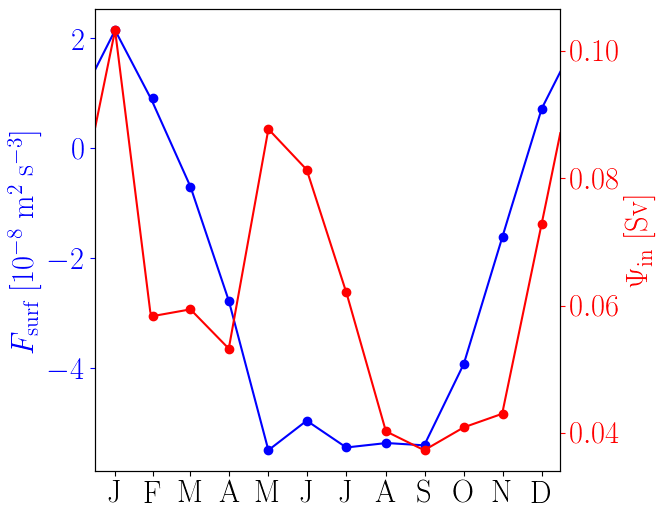

In [6]:
days_per_month   = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_start_month = np.cumsum(np.append(0,days_per_month))
days_mid_month = days_start_month[:-1]+days_per_month/2

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(ts_forcing[365*2:365*3]/86400-365*2, WAIS_Fsurf_forcing[365*2:365*3]*1e8,'b');ax.plot(days_mid_month,WAIS1080_Fsurf_clim*1e8,'bo')
ax.set_xticks(days_mid_month);ax.set_xticklabels(['J', 'F', 'M','A', 'M', 'J','J', 'A', 'S','O', 'N', 'D']);ax.set_xlim([0,364])
ax.set_ylabel(r'$F_\textrm{surf}$ [$10^{-8}$ m$^{2}$ s$^{-3}$]', color='b');ax.tick_params(axis='y', colors='b')
ax1=ax.twinx()
ax1.plot(ts_forcing[365*2:365*3]/86400-365*2, WAIS_Ψin_forcing[365*2:365*3]/translate,'r');ax1.plot(days_mid_month,WAIS1080_Ψin_clim/translate,'ro')
ax1.set_ylabel(r'$\Psi_\textrm{in}$ [Sv]', color='r');ax1.tick_params(axis='y', colors='r')
plt.show()

## create functions to modify/perturb climatological forcings
Want a few options, either add a constant or multiply by a constant the forcing for either all or some subset of months for one or more years...in the end addition of a constant was used though.

In [7]:
def perturbed_climatological_forcing(clim_monthly,N,Δt,y,m,scale_factor, shift_factor):
    n=N+2 # first and last year are not the same as interior due to interpolation, so better to trim them
    days_per_month   = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    days_start_month = np.cumsum(np.append(0,days_per_month))
    days_mid_month = days_start_month[:-1]+days_per_month/2
    ts_monthly = np.append(days_mid_month,349.5+np.cumsum(np.tile(days_per_month,(n-1))))*86400
    ts_forcing = np.arange(0,n*365,Δt)*86400
    monthly_forcing  = np.zeros(12*n);
    month = np.zeros(12*n);
    year = np.zeros(12*n);
    for i in range(n):
        monthly_forcing[i*12:i*12+12] = clim_monthly; monthly_forcing[-1] = clim_monthly[0]
        month[i*12:i*12+12]=np.arange(12)+1; year[i*12:i*12+12]=i
    monthly_forcing = xr.DataArray(monthly_forcing, coords=[ts_monthly], dims=['ts'])
    month = xr.DataArray(month, coords=[ts_monthly], dims=['ts'])
    year = xr.DataArray(year, coords=[ts_monthly], dims=['ts'])
    monthly_forcing = monthly_forcing.assign_coords({'month':month, 'year':year})

    ## perturbation step
    year_mask = xr.DataArray(np.in1d(monthly_forcing.year, y).reshape(monthly_forcing.year.shape),dims=monthly_forcing.year.dims, coords=monthly_forcing.year.coords)
    month_mask = xr.DataArray(np.in1d(monthly_forcing.month, m).reshape(monthly_forcing.month.shape),dims=monthly_forcing.month.dims, coords=monthly_forcing.month.coords)

    if scale_factor != 0:
        perturbed_monthly_forcing = monthly_forcing.where((year_mask==False)|(month_mask==False)).fillna(0)
        perturbed_monthly_forcing = perturbed_monthly_forcing+monthly_forcing.where(year_mask==True).where(month_mask==True).fillna(0)*scale_factor

    if shift_factor !=0:
        perturbed_monthly_forcing = monthly_forcing.where((year_mask==False)|(month_mask==False)).fillna(0)
        perturbed_monthly_forcing = perturbed_monthly_forcing+(monthly_forcing.where(year_mask==True).where(month_mask==True)+shift_factor).fillna(0)

    if (scale_factor==0) and (shift_factor==0):
        print('either shift_factor of scale_factor must be non-zero to impose perturbation')

    func = interp1d(ts_monthly,perturbed_monthly_forcing, 'linear',bounds_error=False)
    forcing = func(ts_forcing) 
    forcing = forcing[np.int(365/Δt):-np.int(365/Δt)]
    ts_forcing = ts_forcing[:-2*np.int(365/Δt)]
    func = interp1d(ts_forcing,forcing, 'cubic',bounds_error=False)
    
    return func, forcing, ts_forcing

## procedure for running the time forced model

1) Inititialize system to steady state (usually create a THICK and THIN mCDW initial condition)

2) Create **functions** (specifically `interp1d` functions) interpolating the intended $F_\textrm{surf}$ and $\Psi_\textrm{in}$ forcing fields to the intended model time.

3) Run model

In [8]:
def ODE_const_forcing(y,t):
    """
    #####
    ODE_const_forcing(y=[h_ww,b_ww],t)
    #####
    ODE definition for the Ice Front (only) Meltwater Overturning Model.
    Supply Ψin and Fsurf values (must be constant).
    Supply params Dict of invariant parameter values.
    returns [h_WW, b_WW]
    """
    L = params["L"];H = params["H"];κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"]
    κ_P    = (κ_conv-κ_diff)/2 * (1-np.tanh(ϕ*(y[1]-b_crit))) + κ_diff
    h_WW   = α*(H-y[0])/L + κ_P/y[0] - Ψ_in/L
    b_WW   = α*(H-y[0])*b_melt/(L*y[0]) - Ψ_in*y[1]/(L*y[0]) + F_surf/y[0] - κ_P*y[1]/(y[0]**2)
    return [h_WW,b_WW]

In [9]:
def ODE_variable_forcing(y,t):
    """
    #####
    ODE_variable_forcing(y=[h_ww,b_ww],t)
    #####
    ODE definition for the Ice Front (only) Meltwater Overturning Model.
    Supply Ψin (function of t) and Fsurf (function of t) values.
    Supply params Dict of invariant parameter values.
    returns [h_WW, b_WW]
    """
    # extract params
    L = params["L"];H = params["H"];κ_diff = params["κ_diff"];κ_conv = params["κ_conv"];b_melt = params["b_melt"];b_crit = params["b_crit"];ϕ = params["ϕ"];α = params["α"]
    κ_P    = (κ_conv-κ_diff)/2 * (1-np.tanh(ϕ*(y[1]-b_crit))) + κ_diff
    h_WW   = α*(H-y[0])/L + κ_P/y[0] - Ψ_in(t)/L
    b_WW   = α*(H-y[0])*b_melt/(L*y[0]) - Ψ_in(t)*y[1]/(L*y[0]) + F_surf(t)/y[0] - κ_P*y[1]/(y[0]**2)
    return [h_WW,b_WW]

In [10]:
def initialize_ODE(b_condition,N, Δt, Ψin, Fsurf, plot=True, parameters = False, percentage = 0.005):
    """
    #####
    initialize_ODE(b_init,N, Δt, Ψin, Fsurf, plot=True, parameters = False, percentage = 0.005)
    #####
    Iterates the provided IF_MWOM ODE function from an initial condition of,
    [h_init = H/2, b_init = {b_melt, if b_condition = 'BUOY', -b_melt if b_condition = 'DENSE', b_condition otherwise}]
    Model is iterated for N years with a timestep of Δt days.
    If plot == True, will generate a plot of model initiatization.
    Supply Ψin and Fsurf values.
    (optional, default provided) Supply params Dict of invariant parameter values.
    (optional, default provided) Supply percentage threshold for convergence criterion.
    returns [h_WW(t), b_WW(t), t (units:days)]
    """
    # default params Dict
    global params
    if parameters == False:
        params = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0025}
    else:
        params = parameters
    global Ψ_in; Ψ_in=Ψin
    global F_surf; F_surf=Fsurf
    
    # initial conditions
    h_init = params["H"]/2;b_melt = params["b_melt"]
    if b_condition == 'DENSE':
        b_init = -b_melt
    elif b_condition == 'BUOY':
        b_init = b_melt
    else:
        b_init = b_condition
    # time dimension
    Δts = Δt*60*60*24 # convert to seconds
    t_init = np.arange(0, N*365*24*60*60, Δts)
    # odeint ODE integration
    soln = odeint(ODE_const_forcing, [h_init,b_init], t_init)
    # extract variables
    h_WW = soln[:,0]; b_WW = soln[:,1]
    # convergence test (last 10 timesteps have a std that is less than percentage% of mean)
    if np.abs(np.std(b_WW[-10:])/np.mean(b_WW[-10:])*100)>percentage:
        print('Convergence Failure')
    elif np.abs(np.std(h_WW[-10:])/np.mean(h_WW[-10:])*100)>percentage:
        print('Convergence Failure')
    if plot == True:
        plt.figure(figsize=(12,5));ax = plt.subplot();ax1=ax.twinx()
        lns1 = ax.plot(t_init/(24*60*60),h_WW,'k', label=r'$h_\mathrm{WW}$'); 
        lns2 = ax1.plot(t_init/(24*60*60),b_WW,'b', label=r'$b_\mathrm{WW}$')
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc=7, fontsize=15)
        ax.set_xlabel('Time (days)', fontsize=15)
        ax.set_ylabel(r'$h_\mathrm{WW}$ [m]', fontsize=15)
        ax1.set_ylabel(r'$b_\mathrm{WW}$ [m s$^{-2}$]', fontsize=15)
        plt.show()
    return [h_WW,b_WW, t_init/(24*60*60), params]

In [11]:
def integrate_ODE(h_init,b_init,Ψin, Fsurf, t_seconds,parameters = False):
    global params
    if parameters == False:
        params = {"L":0.5e5, "H":700, "κ_diff":1e-4, "κ_conv":1e-2, "b_melt":0.0067, "b_crit":5e-4, "ϕ":5e4, "α":0.0025}
    else:
        params = parameters
    global Ψ_in; Ψ_in=Ψin
    global F_surf; F_surf=Fsurf
    
    soln = odeint(ODE_variable_forcing, [h_init,b_init], t_seconds)
    h_WW = soln[:,0]; b_WW = soln[:,1]
   
    return [h_WW,b_WW, t_seconds/(24*60*60), params]

Select values to initialize with

In [12]:
Ψin_init         = WAIS1080_Ψin.mean('time').values;
Fsurf_init_warm  = WAIS1080_Fsurf.mean('time').values
Fsurf_init_cool = -1.3991984e-07

In [13]:
[hWW_cool_init,bWW_cool_init, t_init, params]   = initialize_ODE('DENSE', N=5, Δt=1, Ψin=Ψin_init, Fsurf=Fsurf_init_cool, plot=False, parameters = params, percentage = 0.05)
[hWW_warm_init,bWW_warm_init, t_init, params]     = initialize_ODE('BUOY', N=5, Δt=1, Ψin=Ψin_init, Fsurf=Fsurf_init_warm, plot=False, parameters = params, percentage = 0.05)
hWW_cool_init = hWW_cool_init[-1];bWW_cool_init = bWW_cool_init[-1];hWW_warm_init = hWW_warm_init[-1];bWW_warm_init = bWW_warm_init[-1]

In [14]:
print(hWW_cool_init,bWW_cool_init,hWW_warm_init,bWW_warm_init)

578.1849124405235 -0.0026602769451725982 179.79093607489312 0.005218510845500867


Now force these initialized states with the WAIS 1080 climatological forcing. The climatological forcing supports bistable states for this choice of parameter values, we thus use this forcing as a baseline for our perturbation experiments, as it permits us to text both cool to warm and warm to cool transitions.

In [15]:
## essentially a re-initialisation...
[hWW_cool,bWW_cool, t_days, params] = integrate_ODE(hWW_cool_init,bWW_cool_init,WAIS_Ψin_func, WAIS_Fsurf_func, ts_forcing,parameters = params)
[hWW_warm,bWW_warm, t_days, params] = integrate_ODE(hWW_warm_init,bWW_warm_init,WAIS_Ψin_func, WAIS_Fsurf_func, ts_forcing,parameters = params)
print(hWW_cool[-100],hWW_warm[-100]) # check in bistable regime

589.7754785884048 187.98657553531964


As might be expected from the steady state work, the shallow thermocline is more shallow than observations would suggest. This could be counteracted by increasing $\alpha$ or increasing $\kappa_\mathrm{diff}$ but for this manuscript we have kept with the most defensible (by WAIS 1080 output) and simplest (refraining from tuning the diffusivities) parameter values, and the solutions are not far from realistic.

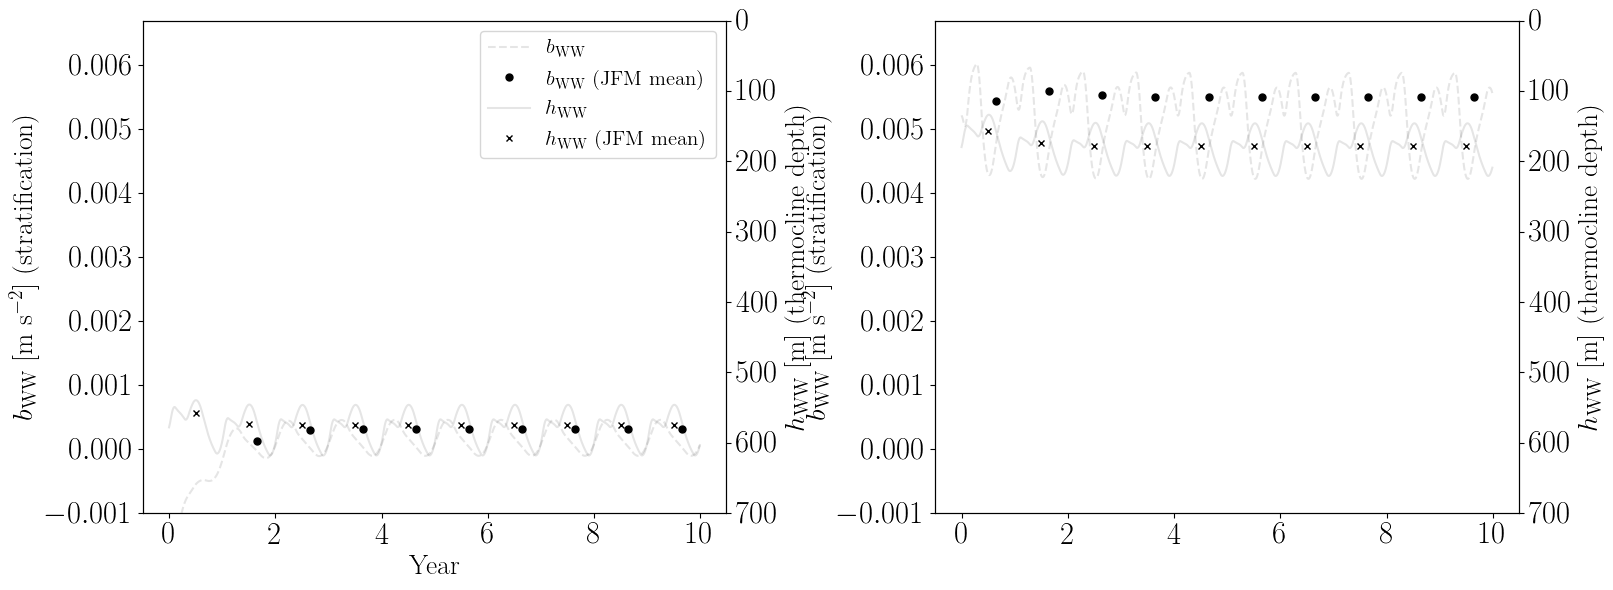

In [16]:
# plot the cool initialized and warm initialized systems

fig, (ax,ax2) = plt.subplots(1, 2, figsize=(16,6))
lns1=ax.plot(t_days/365,bWW_cool, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW_cool.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM mean)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW_cool, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365)/365, axis=1),np.mean(hWW_cool.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM mean)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)',fontsize=20)
ax1.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
lns=lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]

ax2.plot(t_days/365,bWW_warm, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
ax2.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW_warm.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM mean)')
ax3=ax2.twinx()
ax3.plot(t_days/365,hWW_warm, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
ax3.plot(np.nanmean(t_days.reshape(-1, 365)/365, axis=1),np.mean(hWW_warm.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM mean)')# jan-mar mean
ax3.invert_yaxis()
ax2.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)',fontsize=20)
ax3.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)',fontsize=20)


ax.legend(lns, labs, loc=0, fontsize=15,ncol=1)
ax.set_ylim([-0.001,b_melt])
ax1.set_ylim([700,0])
ax2.set_ylim([-0.001,b_melt])
ax3.set_ylim([700,0])


fig.tight_layout()

plt.show()

# Figure 4 c-f

In [17]:
## cold winter experiment 
cold_Fsurf_func, cold_Fsurf_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Fsurf_clim,10,1,[4,5],[5,6,7,8,9],0, -1.35e-7) ## smallest sufficient for the transition in 2 years
[hWW,bWW, t_days, params] = integrate_ODE(hWW_warm[-365],bWW_warm[-365],WAIS_Ψin_func, cold_Fsurf_func, ts_forcing,parameters = params)
print(hWW[0], hWW[-365])

205.54572040736386 597.8241882590819


In [18]:
print(WAIS1080_Fsurf.min().values, cold_Fsurf_forcing.min()) # stronger winter than WAIS 1080 required

-1.6506006161017006e-07 -1.8991639573506006e-07


In [19]:
from matplotlib.transforms import Bbox

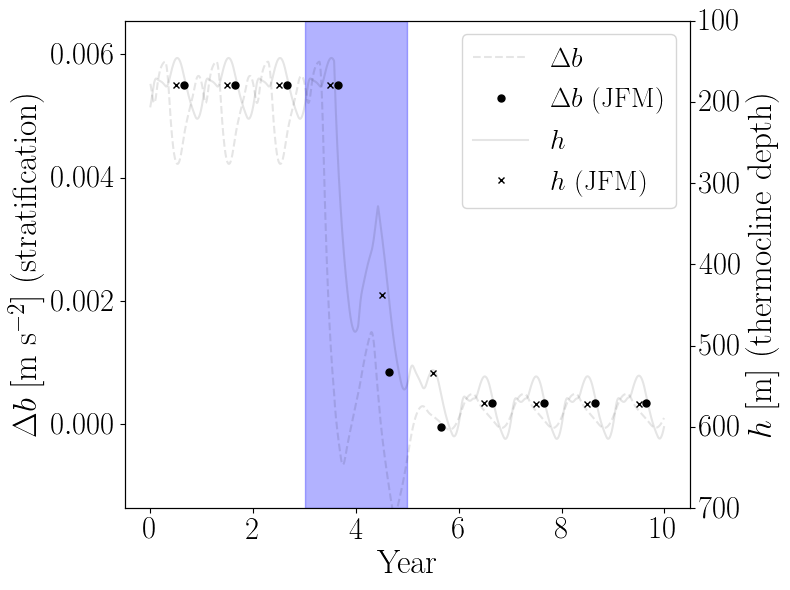

In [20]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$\Delta b$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$\Delta b$ (JFM)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365)/365, axis=1),np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h$ (JFM)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$\Delta b$ [m s$^{-2}$] (stratification)',fontsize=24)
ax1.set_ylabel(r'$h$ [m] (thermocline depth)',fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.axvspan(3, 5, alpha=0.3, color='b')
lns=lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=20,ncol=1)
ax.set_ylim([-0.00136,b_melt-0.00015])
ax1.set_ylim([700,100])
fig.tight_layout()
# ax.axhline(0)
# ax.axhline(b_crit)
# plt.savefig('Figure4_c.png')

plt.show()

In [21]:
## simgle cold winter experiment 
cold_Fsurf_func, cold_Fsurf_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Fsurf_clim,10,1,[4],[5,6,7,8,9],0, -2.5e-7) ## smallest sufficient for the transition in 2 years
[hWW,bWW, t_days, params] = integrate_ODE(hWW_warm[-365],bWW_warm[-365],WAIS_Ψin_func, cold_Fsurf_func, ts_forcing,parameters = params)
print(hWW[0], hWW[-365])

205.54572040736386 600.2699927344372


In [22]:
cold_Fsurf_forcing.min()

-3.0491639573506007e-07

In [23]:
WAIS1080_Fsurf.min()

<xarray.DataArray 'Fsurf' ()>
array(-1.65060062e-07)

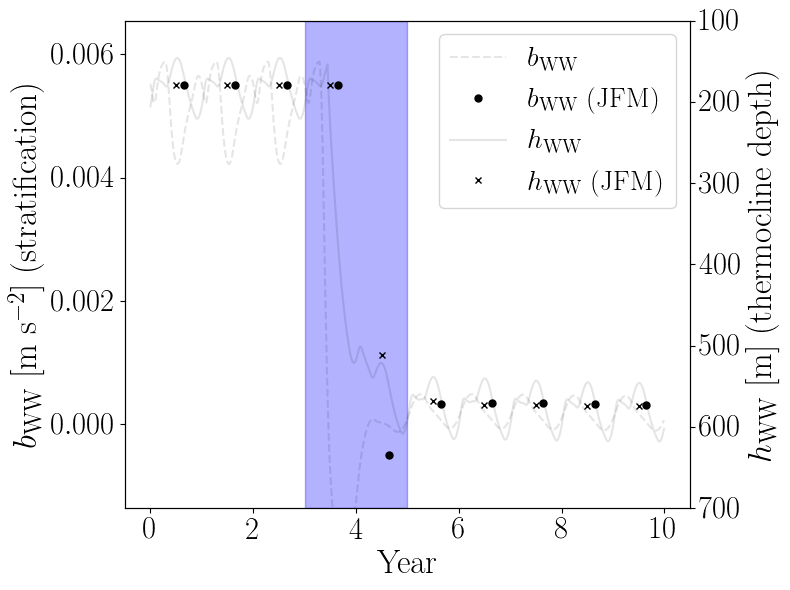

In [24]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365)/365, axis=1),np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)',fontsize=24)
ax1.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)',fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.axvspan(3, 5, alpha=0.3, color='b')
lns=lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=20,ncol=1)
ax.set_ylim([-0.00136,b_melt-0.00015])
ax1.set_ylim([700,100])
fig.tight_layout()
# ax.axhline(b_crit, color='r', linestyle='dashed')
# plt.savefig('Figure4_c.png')

plt.show()

In [25]:
## warm summer experiment 
warm_Fsurf_func, warm_Fsurf_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Fsurf_clim,10,1,[4,5],[12,1,2,3,4],0, 0.5e-8) #note smaller possible but delayed transition
[hWW,bWW, t_days, params] = integrate_ODE(hWW_cool[-365],bWW_cool[-365],WAIS_Ψin_func, warm_Fsurf_func, ts_forcing,parameters = params)
print(hWW[0], hWW[-365])

600.5993358000378 205.66146864318878


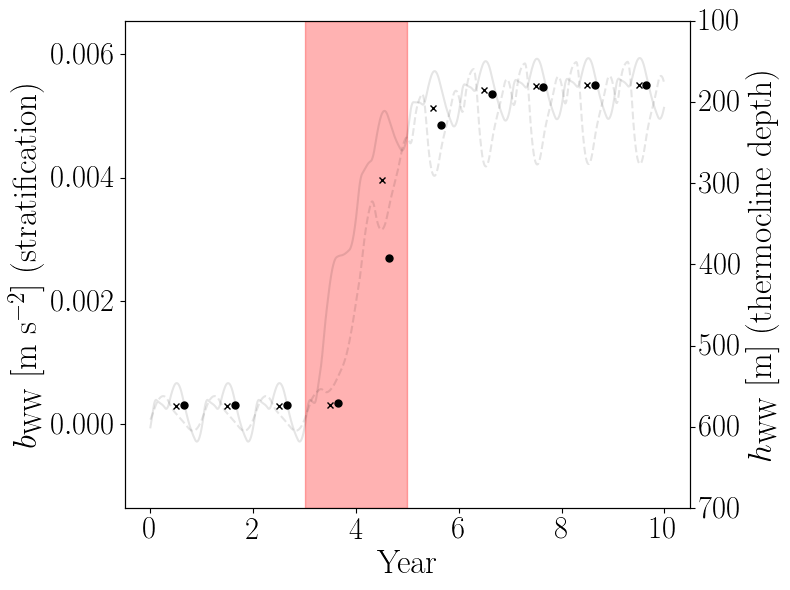

In [26]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM mean)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365), axis=1)/365,np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM mean)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)',fontsize=24)
ax1.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)',fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.set_ylim([-0.00136,b_melt-0.00015])
ax1.set_ylim([700,100])
ax.axvspan(3, 5, alpha=0.3, color='r')
fig.tight_layout()

# plt.savefig('Figure4_e.png')

plt.show()

need to determine the largest possible reduction of $\Psi_\mathrm{in}$ that does not result in negative values

In [27]:
print(WAIS1080_Ψin_clim.mean().values,[WAIS1080_Ψin_clim.min().values*1, WAIS1080_Ψin_clim.max().values*1])

1.1207588760284 [0.6782081784518121, 1.8770095116355203]


In [28]:
## decreased inflow experiment 
reduced_Ψin_func, reduced_Ψin_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Ψin_clim,10,1,[4,5],[5,6,7,8,9],0, -0.679)
[hWW,bWW, t_days, params] = integrate_ODE(hWW_warm[-365],bWW_warm[-365],reduced_Ψin_func, WAIS_Fsurf_func, ts_forcing,parameters = params)
print(reduced_Ψin_forcing.min())
print(hWW[0], hWW[-365])

0.0001079116064974378
205.54572040736386 205.9660400153094


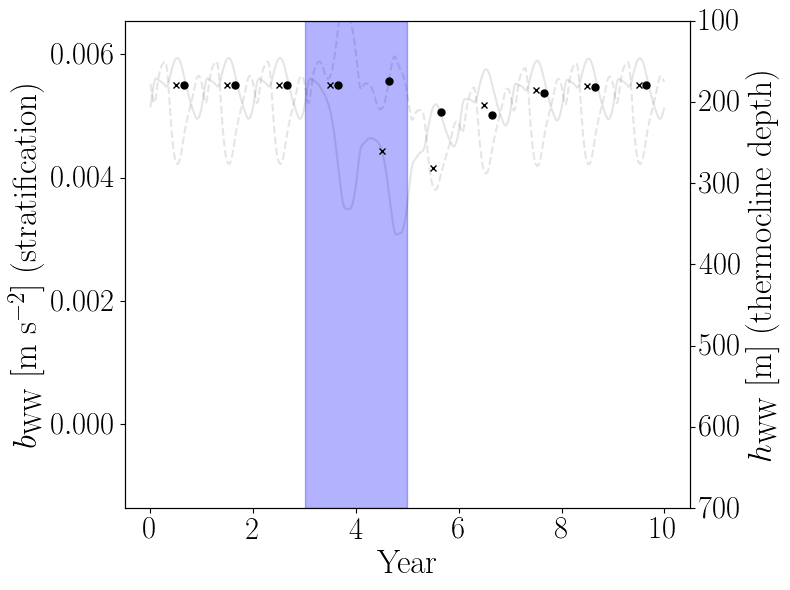

In [29]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM mean)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365), axis=1)/365,np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM mean)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)',fontsize=24)
ax1.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)',fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.set_ylim([-0.00136,b_melt-0.00015])
ax1.set_ylim([700,100])

ax.axvspan(3, 5, alpha=0.3, color='b')
fig.tight_layout()
# plt.savefig('Figure4_d.png')

plt.show()

In [30]:
## decreased inflow experiment (extreme)
xreduced_Ψin_func, xreduced_Ψin_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Ψin_clim,10,1,[3,4,5,6,7],[0,1,2,3,4,5,6,7,8,9,10,11],0, -0.679) 
[hWW,bWW, t_days, params] = integrate_ODE(hWW_warm[-365],bWW_warm[-365],xreduced_Ψin_func, WAIS_Fsurf_func, ts_forcing,parameters = params)
print(xreduced_Ψin_forcing.min())
print(hWW[0], hWW[-365])

0.0001079116064974378
205.54572040736386 222.04736010660895


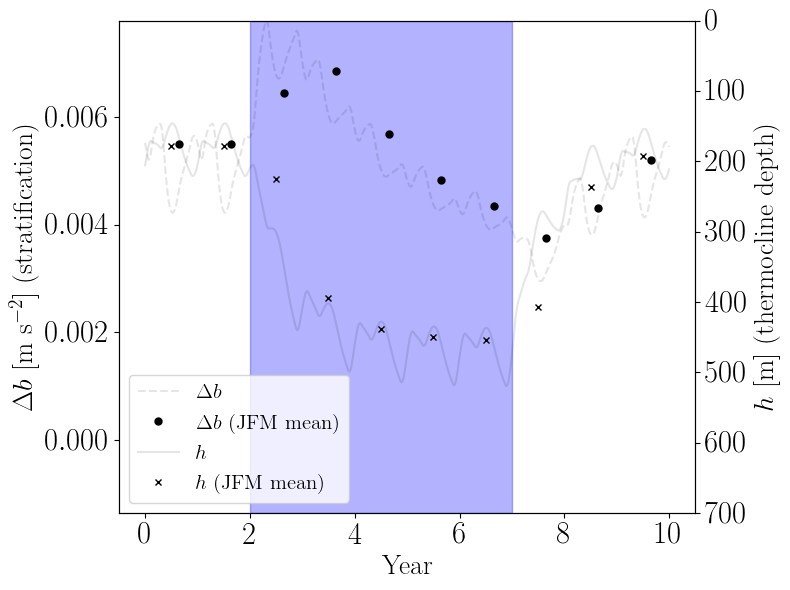

In [31]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$\Delta b$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$\Delta b$ (JFM mean)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365), axis=1)/365,np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h$ (JFM mean)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$\Delta b$ [m s$^{-2}$] (stratification)',fontsize=20)
ax1.set_ylabel(r'$h$ [m] (thermocline depth)',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_ylim([-0.00136,b_melt+0.0011])
ax1.set_ylim([700,0])
lns=lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=15,ncol=1)

ax.axvspan(2, 7, alpha=0.3, color='b')
fig.tight_layout()
# plt.savefig('FigureS4_1.png')


plt.show()

In [32]:
## increased inflow experiment 
increased_Ψin_func, increased_Ψin_forcing, ts_forcing = perturbed_climatological_forcing(WAIS1080_Ψin_clim,10,1,[4,5],[12,1,2,3,4],0, 0.25) ## smallest sufficient for the transition in 2 years
[hWW,bWW, t_days, params] = integrate_ODE(hWW_cool[-365],bWW_cool[-365],increased_Ψin_func, WAIS_Fsurf_func, ts_forcing,parameters = params)
print(hWW[0], hWW[-365])

600.5993358000378 205.5449439502214


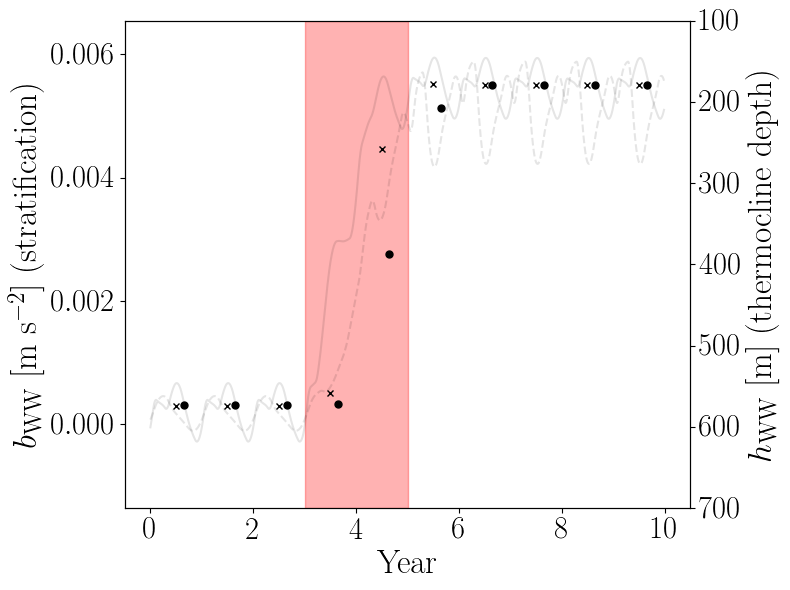

In [33]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,6))
lns1=ax.plot(t_days/365,bWW, 'k--', alpha = 0.1, label=r'$b_\textrm{WW}$')
lns2=ax.plot(np.nanmean(t_days.reshape(-1, 365),axis=1)/365+0.15,np.mean(bWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ko', markersize=5, label=r'$b_\textrm{WW}$ (JFM mean)')
ax1=ax.twinx()
lns3=ax1.plot(t_days/365,hWW, 'k', alpha = 0.1, label=r'$h_\textrm{WW}$')
lns4=ax1.plot(np.nanmean(t_days.reshape(-1, 365), axis=1)/365,np.mean(hWW.reshape(-1, 365)[:,0:31+28+30],axis=1), 'kx', markersize=5, label=r'$h_\textrm{WW}$ (JFM mean)')# jan-mar mean
ax1.invert_yaxis()
ax.set_ylabel(r'$b_\textrm{WW}$ [m s$^{-2}$] (stratification)', fontsize=24)
ax1.set_ylabel(r'$h_\textrm{WW}$ [m] (thermocline depth)', fontsize=24)
ax.set_xlabel('Year',fontsize=24)
ax.axvspan(3, 5, alpha=0.3, color='r')
ax.set_ylim([-0.00136,b_melt-0.00015])
ax1.set_ylim([700,100])

fig.tight_layout()
# plt.savefig('Figure4_f.png')

plt.show()

# Figure 4 a-b

In [34]:
import matplotlib.patches as mpatches
import matplotlib

In [35]:
phase_space = xr.open_dataset('phase_space_cleaned.nc')

In [36]:
def phase_space_plot(ax,ds,translate):
    REGIME = ds.REGIME.load()
    Ψin = ds.Ψin.load()/translate
    Fsurf = ds.Fsurf.load()
    
    ax.contourf(Ψin,Fsurf*1e7,REGIME.where(REGIME==1), cmap='seismic_r',vmin=0,vmax=3)
    ax.contourf(Ψin,Fsurf*1e7,REGIME.where(REGIME==2), cmap='seismic_r',vmin=0,vmax=3)
    ax.contourf(Ψin,Fsurf*1e7,REGIME.where(REGIME==3), cmap='plasma',vmin=0,vmax=3)
    ax.axvline((κ_conv*L/H)/translate,linestyle='dashed', linewidth=1, color='lightpink')
    ax.set_xticks([0,0.1,0.2,0.3]);
    ax.set_xticklabels(['$0$','$0.1$','$0.2$', '$0.3$'],fontsize=20)
    ax.set_xlabel(r'$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=25);ax.set_ylabel(r'$F_\mathrm{surf}\; [10^{-7} \,\mathrm{m}^2\,\mathrm{s}^{-3}]$', fontsize=25)

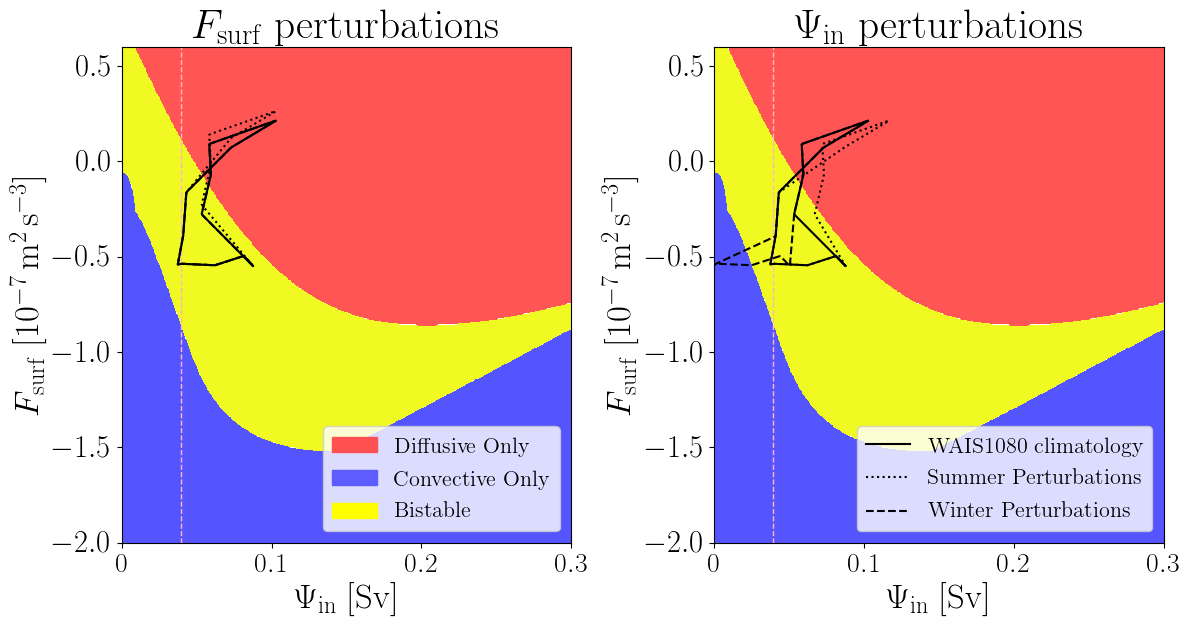

In [37]:
fig, (ax,ax1) = plt.subplots(1, 2, figsize=(12,6))
phase_space_plot(ax,phase_space,translate);
phase_space_plot(ax1,phase_space,translate)#;ax1.set_ylabel(' ')
## Fsurf pertrubations
# ax.plot(WAIS1080_Ψin/translate,WAIS1080_Fsurf*1e7, 'kx',alpha=0.2, markersize=4 , label='WAIS1080 monthly');
ax.plot(WAIS_Ψin_forcing[:365]/translate,WAIS_Fsurf_forcing[:365]*1e7, 'k-',alpha=1, label='WAIS1080 climatology')
ax.plot(WAIS_Ψin_forcing[365*4-40:365*5-40]/translate,cold_Fsurf_forcing[365*4-40:365*5-40]*1e7, 'k--',alpha=1, label='Winter Perturbation')
ax.plot(WAIS_Ψin_forcing[365*4-40:365*5-40]/translate,warm_Fsurf_forcing[365*4-40:365*5-40]*1e7, 'k:',alpha=1, label='Summer Perturbation')
## Ψin perturbations
# ax1.plot(WAIS1080_Ψin/translate,WAIS1080_Fsurf*1e7, 'kx',alpha=0.2, markersize=4 , label='WAIS1080 monthly');
ax1.plot(WAIS_Ψin_forcing[:365]/translate,WAIS_Fsurf_forcing[:365]*1e7, 'k-',alpha=1, label='WAIS1080 climatology')
ax1.plot(increased_Ψin_forcing[365*4-40:365*5-40]/translate,WAIS_Fsurf_forcing[365*4-40:365*5-40]*1e7, 'k:',alpha=1, label='Summer Perturbations')
ax1.plot(reduced_Ψin_forcing[365*4-40:365*5-40]/translate,WAIS_Fsurf_forcing[365*4-40:365*5-40]*1e7, 'k--',alpha=1, label='Winter Perturbations')
ax1.legend(loc=4,fontsize=16)

cmap=matplotlib.cm.get_cmap('seismic_r')
blue_patch = mpatches.Patch(color=cmap(0.66), label='Convective Only')
red_patch = mpatches.Patch(color=cmap(0.33), label='Diffusive Only')
yellow_patch = mpatches.Patch(color='yellow', label='Bistable')
ax.legend(loc=4,handles=[red_patch,blue_patch,yellow_patch], fontsize=16)


fig.tight_layout()
ax.set_title(r'$F_\textrm{surf}$ perturbations',fontsize=30)
ax1.set_title(r'$\Psi_\textrm{in}$ perturbations',fontsize=30)
# plt.savefig('Figure4_ab_optionii.png')

plt.show()

## optional addition of an inset clearer expression of the forcing as a function of time

In [38]:
days_per_month   = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_start_month = np.cumsum(np.append(0,days_per_month))
days_mid_month = days_start_month[:-1]+days_per_month/2

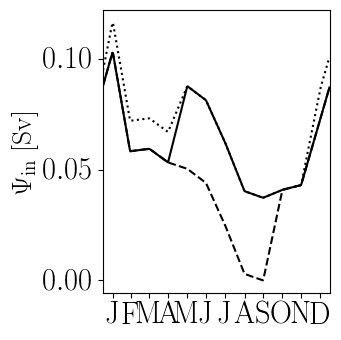

In [39]:
fig, (ax) = plt.subplots(1, 1, figsize=(3.5,3.5))
year = 4
ax.plot(t_days[:365],WAIS_Ψin_forcing[(year-1)*365:year*365]/translate, 'k-')
ax.plot(t_days[:365],reduced_Ψin_forcing[(year-1)*365:year*365]/translate, 'k--')
ax.plot(t_days[:365],increased_Ψin_forcing[(year-1)*365:year*365]/translate, 'k:')
ax.set_ylabel(r'$\Psi_\mathrm{in}\; [\mathrm{Sv}]$', fontsize=20)
ax.set_xticks(days_mid_month)
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_xlim([0,365])
fig.tight_layout()
plt.savefig('Figure4_inset1.png')

plt.show()

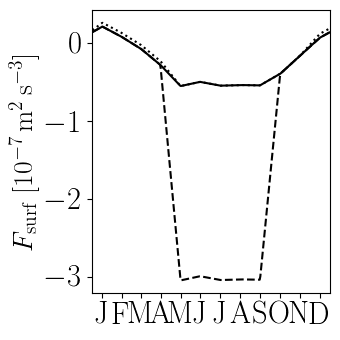

In [40]:
fig, (ax) = plt.subplots(1, 1, figsize=(3.5,3.5))
year = 4
ax.plot(t_days[:365],WAIS_Fsurf_forcing[(year-1)*365:year*365]*1e7, 'k-')
ax.plot(t_days[:365],cold_Fsurf_forcing[(year-1)*365:year*365]*1e7, 'k--')
ax.plot(t_days[:365],warm_Fsurf_forcing[(year-1)*365:year*365]*1e7, 'k:')
ax.set_ylabel(r'$F_\mathrm{surf}\; [10^{-7} \,\mathrm{m}^2\,\mathrm{s}^{-3}]$', fontsize=20)
ax.set_xticks(days_mid_month)
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax.set_xlim([0,365])
fig.tight_layout()
plt.savefig('Figure4_inset2.png')

plt.show()

## related supplementary information (forced with full forcing timeseries)

In [41]:
n=27 # first and last year are not the same as interior due to interpolation, so better to trim them
days_per_month   = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
days_start_month = np.cumsum(np.append(0,days_per_month))[:12]
ts_start_month   = np.append(np.append(days_start_month,334+np.cumsum(np.tile(days_per_month,(n-1)))),(9824+31))*86400
ts_daily         = np.arange(0,ts_start_month[-1],86400)


monthly_forcing = WAIS1080_Fsurf[11:-1]
func = interp1d(ts_start_month,monthly_forcing, 'linear',bounds_error=False)
forcing = func(ts_daily) 
WAIS_Fsurf_full_func = interp1d(ts_daily,forcing, 'linear',bounds_error=False)

monthly_forcing = WAIS1080_Ψin[11:-1]
func = interp1d(ts_start_month,monthly_forcing, 'linear',bounds_error=False)
forcing = func(ts_daily) 
WAIS_Ψin_full_func = interp1d(ts_daily,forcing, 'linear',bounds_error=False)

In [42]:
# repeat of code in Supplementary_2
theta = xr.open_dataset('WAIS1080_DIS_front_hovmollers.nc').THETA

# for this purpose it's simple to define the thermocline as the 0C isotherm
isotherm_0C_timeseries = xr.DataArray(np.zeros(len(theta.time)), coords = [theta.time], dims=['time'], attrs=[{'(spatially averaged) depth of the 0C isotherm (below 200m) at the DIS front from monthly output [m]', 'description'}])
for i in range(len(isotherm_0C_timeseries)):
    column_temp = theta.sel(Z = slice(-200,-1000)).isel(time=i) # trim surface
    isotherm_0C_timeseries[i]=np.interp(0,column_temp,column_temp.Z)

# we'll need the mean depth to convert isotherm depth (h) to cdw thickness (hcdw)
H=786
h_WAIS1080 = -isotherm_0C_timeseries

In [43]:
[hWW_cold_full,bWW_cold_full, t_days, params] = integrate_ODE(hWW_cool[-365],bWW_cool[-365],WAIS_Ψin_full_func, WAIS_Fsurf_full_func, ts_daily,parameters = params)
[hWW_warm_full,bWW_warm_full, t_days, params] = integrate_ODE(hWW_warm[-365],bWW_warm[-365],WAIS_Ψin_full_func, WAIS_Fsurf_full_func, ts_daily,parameters = params)


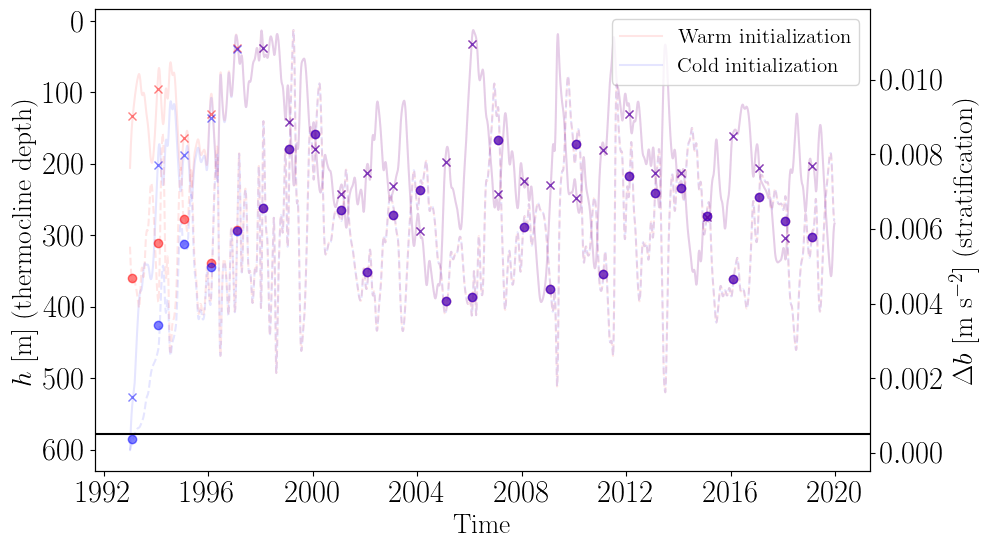

In [44]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
lns1=ax1.plot(np.arange('1993-01-01','2020-01-01', dtype='datetime64[D]')[:-6], hWW_warm_full, 'r', alpha=0.1, label =r'Warm initialization' )# leaps years threw this off...
lns2=ax1.plot(np.arange('1993-01-01','2020-01-01', dtype='datetime64[D]')[:-6], hWW_cold_full, 'b', alpha=0.1, label =r'Cold initialization' )
ax1.plot(np.arange('1993-02-01','2020-02-01', dtype='datetime64[M]')[0::12],np.mean(hWW_warm_full.reshape(-1, 365)[:,0:31+28+30],axis=1), 'rx', alpha=0.5,label=r'Warm initialization (JFM mean)')# jan-mar mean
ax1.plot(np.arange('1993-02-01','2020-02-01', dtype='datetime64[M]')[0::12],np.mean(hWW_cold_full.reshape(-1, 365)[:,0:31+28+30],axis=1), 'bx', alpha=0.5,label=r'Cold initialization (JFM mean)')# jan-mar mean

ax=ax1.twinx()
ax.plot(np.arange('1993-01-01','2020-01-01', dtype='datetime64[D]')[:-6], bWW_warm_full, 'r--', alpha=0.1, label =r'Warm initialization' )# leaps years threw this off...
ax.plot(np.arange('1993-01-01','2020-01-01', dtype='datetime64[D]')[:-6], bWW_cold_full, 'b--', alpha=0.1, label =r'Cold initialization' )
ax.plot(np.arange('1993-02-01','2020-02-01', dtype='datetime64[M]')[0::12],np.mean(bWW_warm_full.reshape(-1, 365)[:,0:31+28+30],axis=1), 'ro', alpha=0.5,label=r'Warm initialization (JFM mean)')# jan-mar mean
ax.plot(np.arange('1993-02-01','2020-02-01', dtype='datetime64[M]')[0::12],np.mean(bWW_cold_full.reshape(-1, 365)[:,0:31+28+30],axis=1), 'bo', alpha=0.5,label=r'Cold initialization (JFM mean)')# jan-mar mean
ax.axhline(b_crit,color='k')

# ax1.plot(h_WAIS1080.time, h_WAIS1080, 'k', alpha=0.1)
# ax1.plot(np.arange('1993-02-01','2020-02-01', dtype='datetime64[M]')[0::12], np.mean(h_WAIS1080[11:-2].values.reshape(-1,12)[:,0:3],axis=1), 'kx')
# ax1.set_ylim([620,200])
ax1.set_ylabel(r'$h$ [m] (thermocline depth)',fontsize=20)
ax.set_ylabel(r'$\Delta b$ [m s$^{-2}$] (stratification)',fontsize=20)
ax1.set_xlabel('Time',fontsize=20)
lns=lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1, fontsize=15,ncol=1)

np.mean(h_WAIS1080[11:-2].values.reshape(-1,12)[:,0:3],axis=1)
ax1.invert_yaxis()
# plt.savefig('FigureS4_2.png',bbox_inches = "tight")

plt.show()